In this project, I have cleaned the dataset by filling missing values, removing $ signs and other characters from numerical variables, carried out feature engineering, and transformed the skewed data using log and sqrt transformations to reduce the impact of outliers for price prediction. I have also encoded categorical features with dummy and target encoding techniques. Next, I have implemented linear methods such as GLM, Ridge and Lasso regressions. For the final model, I have chosen Gradient Boosting regressor with LightGBM module as linear models perform poor due to the categorical features. I have implemented tuning for the final model, and explained the regression errors using SHAP contributions, and build surrogate tree for residual analysis. Lastly, I have created a pipeline function that combines all the above steps, training and predicting unseen data. The steps are the following:

1. **Load, Clean, Preprocess, and Feature Engineer**
2. **Linear Regression**
3. **Gradient Boosting regression and tuning**
4. **Model explainability**
5. **Residual Analysis**
6. **Final Pipeline**

# load Packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
!pip install category_encoders
from sklearn.preprocessing import OneHotEncoder
import category_encoders
from category_encoders.target_encoder import TargetEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

!pip install lightgbm
import lightgbm as lgbm

from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Cleaning and Feature Engineering

In [2]:
#Load Dataset
cars=pd.read_csv('Car_prices_project_2.zip')
print(cars.shape)
cars.head(3)

(106134, 10)


,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,seat,leon,gen-i-1999-2005-leon,1999,169000,1600,Gasoline,Gubin,Lubuskie,3999
1,volvo,xc-60,gen-ii-2017,2019,65942,1969,Diesel,Warszawa,Mazowieckie,169999
2,mazda,cx-3,NaN,2019,76000,1998,Gasoline,Zielona Góra,Lubuskie,95900


In [3]:
# check na's in each column
cars.isna().any()

mark               False
model              False
generation_name     True
year               False
mileage            False
vol_engine         False
fuel               False
city               False
province           False
price              False
dtype: bool

In [4]:
def clean_engineer_cars(cars):
  """
  input: raw cars dataframe
  ouput: clean dataframe with new features
  """
  # fill Na for generation_name feature using the combination of related features
  cars['generation_name'].fillna(cars['mark']+cars['model']+cars['year'].astype('string'),inplace=True)

  # Since price may not change linearly in year, I am creating another variable 
  # to represent diminishing depreciation of car's value using log(age) feature. 
  max_year=cars['year'].max()
  cars['log_age']=np.log(max_year-cars['year']+1)

  # create a new variable of mileage and year
  cars['mileage_per_year']=cars['mileage']/(max_year-cars['year']+1)
  
  #create a feature using nonlinear function of vol_engine
  cars['sqrt_vol_eng']=np.sqrt(cars['vol_engine'])
  
  return cars

In [5]:
# Apply the defined function on cars dataset
cars=clean_engineer_cars(cars)
cars.head(3)

,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,log_age,mileage_per_year,sqrt_vol_eng
0,seat,leon,gen-i-1999-2005-leon,1999,169000,1600,Gasoline,Gubin,Lubuskie,3999,3.178054,7041.666667,40.000000
1,volvo,xc-60,gen-ii-2017,2019,65942,1969,Diesel,Warszawa,Mazowieckie,169999,1.386294,16485.500000,44.373415
2,mazda,cx-3,mazdacx-32019,2019,76000,1998,Gasoline,Zielona Góra,Lubuskie,95900,1.386294,19000.000000,44.698993


# Linear Models

In [6]:
x_train,x_test,y_train,y_test=train_test_split(cars.drop(columns='price'),cars['price'],test_size=0.2,random_state=42)
x_train.reset_index(drop=True,inplace=True)
x_test.reset_index(drop=True,inplace=True)
print(x_train.shape,x_test.shape)
print(x_train.nunique())

(84907, 12) (21227, 12)
mark                   23
model                 328
generation_name      2104
year                   53
mileage             27100
vol_engine            466
fuel                    6
city                 3868
province               21
log_age                53
mileage_per_year    32824
sqrt_vol_eng          466
dtype: int64


## Encode

In [7]:
# Create dummy columns for Fuel categories
ohe=OneHotEncoder(handle_unknown='ignore', sparse=False,drop='first')
ohe.fit(x_train['fuel'].values.reshape(-1, 1))
col_names=[col[3:] for col in ohe.get_feature_names()]
x_train[col_names]=pd.DataFrame(ohe.transform(x_train['fuel'].values.reshape(-1, 1))
,columns=col_names)
x_test[col_names]=pd.DataFrame(ohe.transform(x_test['fuel'].values.reshape(-1, 1))
,columns=col_names)
x_train.drop(columns='fuel',inplace=True)
x_test.drop(columns='fuel',inplace=True)
print(x_train.shape,x_test.shape)

(84907, 16) (21227, 16)


In [8]:
numerical=['mileage','vol_engine','mileage_per_year','log_age', 'sqrt_vol_eng','year']
drop_cols=[]
target_cols=[]
for col in x_train.drop(columns=numerical+col_names).columns:
    te=TargetEncoder(handle_missing='value',handle_unknown='value', min_samples_leaf=5, smoothing=0.1)
    te.fit(x_train[col], y_train.values)
    x_train[col+'_te']=te.transform(x_train[col])
    x_test[col+'_te']=te.transform(x_test[col])
    drop_cols.append(col)
    target_cols.append(col+'_te')
x_train.drop(columns=drop_cols,inplace=True)
x_test.drop(columns=drop_cols,inplace=True)
print(x_train.shape,x_test.shape)
x_train[target_cols].head(3)

(84907, 16) (21227, 16)


,mark_te,model_te,generation_name_te,city_te,province_te
0,47945.856269,8735.751553,8859.476190,70659.331893,67095.379846
1,59167.701422,34823.430556,14219.521739,100244.631579,85439.733370
2,51250.116770,11459.449153,11459.449153,30701.238806,55265.808081


## Linear Models

### Linear Regression Model

In [ ]:
reg=LinearRegression(normalize=False)
reg.fit(x_train,y_train)
pred=reg.predict(x_test)
print('MSE =',mean_squared_error(y_test,pred))
print('MAE=',mean_absolute_error(y_test,pred))
print('R_sq=',reg.score(x_test,y_test))
[[col,coef] for (col,coef) in zip(x_train.columns,reg.coef_)]

MSE = 1013371162.6990268
MAE= 16052.098636892544
R_sq= 0.8557536698231651


[['year', -191.2085643031707],
 ['mileage', -0.029110265774625166],
 ['vol_engine', 28.369386388245086],
 ['log_age', -21365.680682358445],
 ['mileage_per_year', -0.6683867990705321],
 ['sqrt_vol_eng', -1181.8142221093915],
 ['Diesel', 126.93373553167777],
 ['Electric', -2216.1248873397917],
 ['Gasoline', -1249.9517424749579],
 ['Hybrid', 14400.467739639736],
 ['LPG', -1837.1172857878203],
 ['mark_te', -0.004943655490063205],
 ['model_te', 0.15974366684085067],
 ['generation_name_te', 0.6883977145037331],
 ['city_te', 0.08165260166541108],
 ['province_te', 0.008656759135992113]]

### Ridge Regression

In [ ]:
ridge=Ridge(alpha=1)
ridge.fit(x_train,y_train)
pred=ridge.predict(x_test)
print('MSE =',mean_squared_error(y_test,pred))
print('MAE=',mean_absolute_error(y_test,pred))
print('R_sq=',ridge.score(x_test,y_test))
[[col,coef] for (col,coef) in zip(x_train.columns,ridge.coef_)]

MSE = 1013372818.0636752
MAE= 16052.078006607311
R_sq= 0.8557534341935316


[['year', -190.55993566928046],
 ['mileage', -0.029103504151197935],
 ['vol_engine', 28.366929830235332],
 ['log_age', -21360.37543354417],
 ['mileage_per_year', -0.6685399830891195],
 ['sqrt_vol_eng', -1181.5601887769956],
 ['Diesel', -115.8942931038408],
 ['Electric', -2448.63729998119],
 ['Gasoline', -1492.6796809121486],
 ['Hybrid', 14150.400499455598],
 ['LPG', -2078.7106776014543],
 ['mark_te', -0.0049449839324781225],
 ['model_te', 0.15973973491079974],
 ['generation_name_te', 0.6884064428512174],
 ['city_te', 0.08165765918064695],
 ['province_te', 0.008657344129872943]]

### Lasso Regression

In [ ]:
lasso=Lasso(alpha=6,normalize=False)
lasso.fit(x_train,y_train)
pred=lasso.predict(x_test)
print('MSE =',mean_squared_error(y_test,pred))
print('MAE=',mean_absolute_error(y_test,pred))
print('R_sq=',lasso.score(x_test,y_test))
[[col,coef] for (col,coef) in zip(x_train.columns,lasso.coef_)]

MSE = 1013368689.7180629
MAE= 16049.237546499651
R_sq= 0.855754021834789


[['year', -171.25809872266467],
 ['mileage', -0.028845699304147033],
 ['vol_engine', 28.104597814407025],
 ['log_age', -21226.192744034473],
 ['mileage_per_year', -0.6724306073857165],
 ['sqrt_vol_eng', -1154.9323134506812],
 ['Diesel', 1330.3806521553388],
 ['Electric', -0.0],
 ['Gasoline', -0.0],
 ['Hybrid', 15360.950994427943],
 ['LPG', -416.8034329101781],
 ['mark_te', -0.004968027920150435],
 ['model_te', 0.1595674848392613],
 ['generation_name_te', 0.6886322715309108],
 ['city_te', 0.08176138361870293],
 ['province_te', 0.008621545921228815]]

## Grid Search with Ridge

In [ ]:
ridge=Ridge()
param_grid={'alpha':np.linspace(0,10,50)}
grid=GridSearchCV(ridge,param_grid, scoring='neg_mean_squared_error',cv=10)
grid.fit(x_train,y_train)
grid.best_estimator_

Ridge(alpha=10.0)

In [ ]:
ridge=grid.best_estimator_
ridge.fit(x_train,y_train)
pred=ridge.predict(x_test)
print('MSE =',mean_squared_error(y_test,pred))
print('MAE=',mean_absolute_error(y_test,pred))
print('R_sq=',lasso.score(x_test,y_test))
[[col,coef] for (col,coef) in zip(x_train.columns,ridge.coef_)]

MSE = 1013386006.3333514
MAE= 16051.748228770723
R_sq= 0.855754021834789


[['year', -184.6121452012953],
 ['mileage', -0.02904068686075838],
 ['vol_engine', 28.336790833442628],
 ['log_age', -21311.908239449014],
 ['mileage_per_year', -0.669901516573664],
 ['sqrt_vol_eng', -1178.4965165740189],
 ['Diesel', -994.4973512077462],
 ['Electric', -3203.1974978165044],
 ['Gasoline', -2369.5995288646322],
 ['Hybrid', 13212.292878483318],
 ['LPG', -2943.1256508452016],
 ['mark_te', -0.00495815802499787],
 ['model_te', 0.15970167786649644],
 ['generation_name_te', 0.688483634442957],
 ['city_te', 0.08170490168367783],
 ['province_te', 0.008667353204790342]]

All of the above linear models performed poorly, because the data does not follow a linear pattern. Next we will try  GBM Tree Regression models.

# LIGHTGBM without encoding

## Data preprocessing

In [ ]:
# reload the data and perform data cleaning and feature engineering function
cars=pd.read_csv('Car_prices_project_2.zip')
cars=clean_engineer_cars(cars)

# convert the dtype of categorical features to 'category' type 
# this makes sure that this features will be automatically recognized as categorical features by lgbm
for col in cars.columns:
  if cars[col].dtype=='object':
    cars[col]=cars[col].astype('category')
    
# Split the frame into train and test
x_train,x_test,y_train,y_test=train_test_split(cars.drop(columns='price'),cars['price'],test_size=0.2,random_state=42)


## Simple LGBM Regression Model

In [ ]:
model = lgbm.LGBMRegressor(learning_rate=0.05,random_state=42,
                           early_stopping=50,max_depth=10, 
                           n_estimators=1000,num_leaves=60, metric='mae')
model.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],
          verbose=0)

LGBMRegressor(early_stopping=50, learning_rate=0.05, max_depth=10,
              n_estimators=1000, num_leaves=60, random_state=42)

In [ ]:
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))
print('MSE=',mean_squared_error(y_test,model.predict(x_test)))
print('RMSE=',np.sqrt(mean_squared_error(y_test,model.predict(x_test))))
print('MAE=',mean_absolute_error(y_test,model.predict(x_test)))

Testing accuracy 0.9495
MSE= 355104409.22339803
RMSE= 18844.214210823386
MAE= 8168.574891071147


## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create parameters to search
grid_params = {
              'num_leaves': [40,60],
              'colsample_bytree': [0.5, 0.65, 0.8], 
              'subsample': [0.5, 0.65, 0.8],
               'max_depth':[-1,8,15]
              }
mod = lgbm.LGBMRegressor(early_stopping_round=40,n_estimators=1000,learning_rate=0.03,subsample_for_bin=10000,metric='l1')

# Create the grid
grid = GridSearchCV(mod, param_grid=grid_params, verbose=1, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
# Run the grid
grid.fit(x_train, y_train,eval_set=[(x_test,y_test)])

In [ ]:
# Print the best parameters found
print(grid.best_estimator_)
print(grid.best_score_)

LGBMRegressor(colsample_bytree=0.65, early_stopping_round=40,
              learning_rate=0.03, metric='l1', n_estimators=1000, num_leaves=60,
              subsample=0.5, subsample_for_bin=10000)
-8291.961253168794


In [ ]:
best=lgbm.LGBMRegressor(colsample_bytree=0.65, early_stopping_round=40,
              learning_rate=0.03, metric='l1', n_estimators=3000, num_leaves=60,
              subsample=0.5, subsample_for_bin=10000)
best.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)])

In [ ]:
pred=best.predict(x_test)
print('Testing accuracy {:.4f}'.format(best.score(x_test,y_test)))
print('MSE=',mean_squared_error(y_test,pred))
print('RMSE=',np.sqrt(mean_squared_error(y_test,pred)))
print('MAE=',mean_absolute_error(y_test,pred))

Testing accuracy 0.9509
MSE= 344998011.6464996
RMSE= 18574.122096252613
MAE= 7768.569249827285


# LIGHTGBM with target encoded data

## Splitting data and target encoding

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(cars.drop(columns='price'),cars['price'],test_size=0.2,random_state=42)

In [ ]:
numerical=['mileage','vol_engine','mileage_per_year','log_age', 'sqrt_vol_eng','year']
drop_cols=[]
target_cols=[]
for col in x_train.drop(columns=numerical).columns:
    te=TargetEncoder(handle_missing='value',handle_unknown='value', min_samples_leaf=5, smoothing=0.05)
    te.fit(x_train[col], y_train.values)
    x_train[col+'_te']=te.transform(x_train[col])
    x_test[col+'_te']=te.transform(x_test[col])
    drop_cols.append(col)
    target_cols.append(col+'_te')
# x_train.drop(columns=drop_cols,inplace=True)
# x_test.drop(columns=drop_cols,inplace=True)
print(x_train.shape,x_test.shape)
x_train[target_cols].head(2)

(84907, 18) (21227, 18)


,mark_te,model_te,generation_name_te,fuel_te,city_te,province_te
80686,47945.856269,8735.751553,8859.476190,66268.967899,70659.331893,67095.379846
98823,59167.701422,34823.430556,14219.521739,72518.317495,100244.631579,85439.733370


## Lucky Models

### Model 1

In [ ]:
model = lgbm.LGBMRegressor(colsample_bytree=0.5, learning_rate=0.02,random_state=42,subsample_for_bin=10000,
                           max_depth=20, n_estimators=2000,num_leaves=40,metric='l1')
model.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],
          verbose=1)

In [ ]:
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))
print('MSE=',mean_squared_error(y_test,model.predict(x_test)))
print('RMSE=',np.sqrt(mean_squared_error(y_test,model.predict(x_test))))
print('MAE=',mean_absolute_error(y_test,model.predict(x_test)))

Testing accuracy 0.9537
MSE= 325022404.5108107
RMSE= 18028.377755938294
MAE= 7832.124100098974


### Model 2

In [ ]:
model = lgbm.LGBMRegressor(subsample=0.5,colsample_bytree=0.5, learning_rate=0.05,random_state=42,subsample_for_bin=15000,
                           max_depth=-1, n_estimators=3000,num_leaves=60,metric='l1')
model.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],
          verbose=0)

LGBMRegressor(colsample_bytree=0.5, learning_rate=0.05, metric='l1',
              n_estimators=3000, num_leaves=60, random_state=42, subsample=0.5,
              subsample_for_bin=15000)

In [ ]:
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))
print('MSE=',mean_squared_error(y_test,model.predict(x_test)))
print('RMSE=',np.sqrt(mean_squared_error(y_test,model.predict(x_test))))
print('MAE=',mean_absolute_error(y_test,model.predict(x_test)))

Testing accuracy 0.9520
MSE= 337484098.9162949
RMSE= 18370.74029309366
MAE= 7557.223363301699


### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create parameters to search
grid_params = {
              'num_leaves': [40, 60, 70],
              'colsample_bytree': [0.4, 0.5, 0.6, 0.8], 
              'subsample': [0.4, 0.5, 0.6, 0.8]
              }
mod = lgbm.LGBMRegressor(learning_rate=0.05, n_estimators=3000, subsample_for_bin=10000, metric='l1', max_depth=-1)

# Create the grid
grid_te = GridSearchCV(mod, param_grid=grid_params, verbose=0, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
# Run the grid
grid_te.fit(x_train, y_train,eval_set=[(x_test,y_test)])

In [ ]:
grid_te.best_estimator_

LGBMRegressor(colsample_bytree=0.5, learning_rate=0.05, metric='l1',
              n_estimators=3000, num_leaves=60, subsample=0.4,
              subsample_for_bin=10000)

# Final Model

In [ ]:
# The best model from the last grid search results
best=lgbm.LGBMRegressor(colsample_bytree=0.5, learning_rate=0.05, metric='l1',
              n_estimators=3000, num_leaves=60, subsample=0.4,
              subsample_for_bin=10000,random_state=0)
best.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],
          verbose=0)

LGBMRegressor(colsample_bytree=0.5, learning_rate=0.05, metric='l1',
              n_estimators=3000, num_leaves=60, random_state=0, subsample=0.4,
              subsample_for_bin=10000)

In [ ]:
print('Testing accuracy {:.4f}'.format(best.score(x_test,y_test)))
print('MSE=',mean_squared_error(y_test,best.predict(x_test)))
print('RMSE=',np.sqrt(mean_squared_error(y_test,best.predict(x_test))))
print('MAE=',mean_absolute_error(y_test,best.predict(x_test)))

Testing accuracy 0.9509
MSE= 344794658.7574345
RMSE= 18568.647197828777
MAE= 7566.109415921832


**Final Model Decision**

Comparing the performance of implemented models on the test set,the model given above is the best choice, because it has the lowest MAE. The reason I am choosing MAE ove MSE as the main performance metric is that we can consider the difference between actual price and estimated price as the cost (cost of buying a car for more than or selling it for less that its actual price, depending on the purpose of the model). And the cost of 200 can be considered twice as much as cost of 100, therefore abs value error make sense to me.

## Permutation Feature Importance

In [ ]:
# Initialize a list of results
results = []
mae_full_mod=mean_absolute_error(y_test,best.predict(x_test))
# Iterate through each predictor
for predictor in x_test:
    
    # Create a copy of x_test
    x_test_copy = x_test.copy()
    
    # Scramble the values of the given predictor
    x_test_copy[predictor] = x_test[predictor].sample(frac=1).values
    
    # Calculate the new MAE
    new_mae = mean_absolute_error(best.predict(x_test_copy), y_test)
    
    # Append the increase in MAE to the list of results 
    results.append({'pred': predictor,
                    'score': new_mae - mae_full_mod })
# Convert to a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score',
                                              ascending = False)

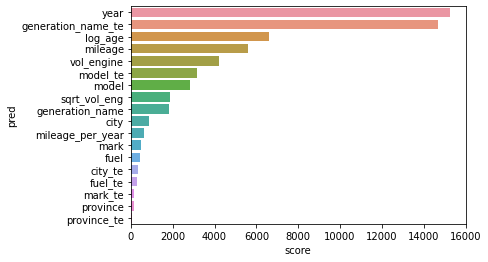

In [ ]:
sns.barplot(data=resultsdf,x='score',y='pred')
plt.show()

Year (and log age), generation_name_te (target_encoded), and mileage are the most imortant features based on permutation feature importance plot.

## Shap contributions and Residual Analysis

In [ ]:
#!pip install shap
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(x_test)

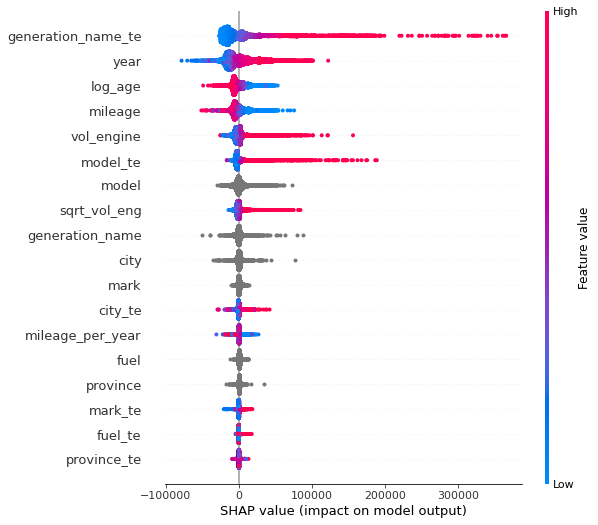

In [ ]:
shap.summary_plot(shap_values, x_test)

Generation_name (target encoded), year (+ log age feature), mileage are the most important original features that contributes to the predictions.

In [ ]:
# import copy
test_yhat = x_test.copy()
test_yhat['price']=y_test
yhat = 'pred_price'
resid = 'r_price'
test_yhat[yhat] = best.predict(x_test)

# Find abs. error
y='price'
test_yhat[resid] = np.abs(test_yhat[y]-test_yhat[yhat])

# add shap contributions to the data
cols_shap=[col+'_cont' for col in x_test.columns]
test_yhat[cols_shap]=shap_values

test_yhat = test_yhat.sort_values(by=resid, ascending=False).reset_index(drop=True)
test_yhat.head(3)

# Define feature_values and shap values
shap_columns = cols_shap.copy()
ftr_columns = x_test.columns.copy()
shap_contribs = test_yhat[cols_shap]
ftr_values =test_yhat[ftr_columns]

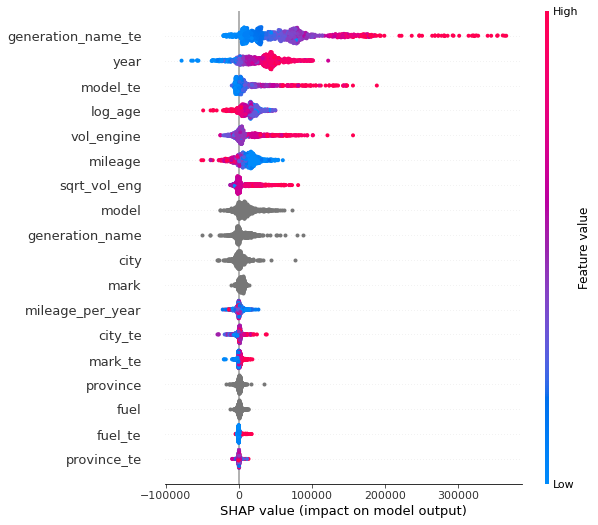

In [ ]:
shap.summary_plot(shap_values=shap_contribs.values[0:1000],
                  features=ftr_values[0:1000])

Shap summary plot for top 1000 predictions with the highest absolute error. Seems like the target encoded variables are the main cause of high residuals.

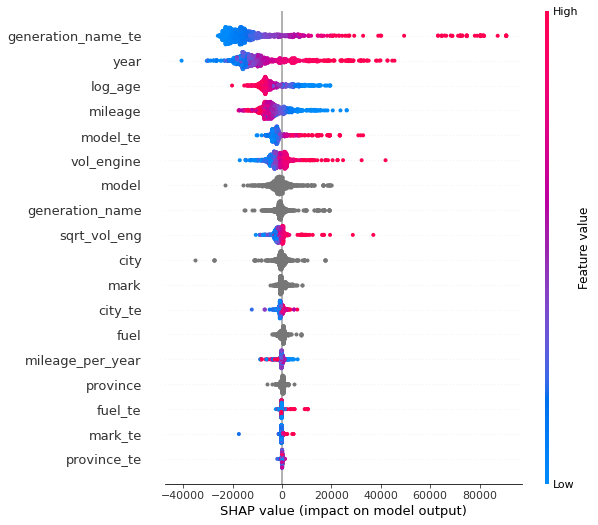

In [ ]:
shap.summary_plot(shap_values=shap_contribs.values[-1000:],
                  features=ftr_values[-1000:])

Shap summary plot for bottom 1000 (most correct predictions)

### Local SHAP Plots

In [ ]:
# create a function to get local shap plot
def ind_shap_plot(explainer, combined_df, shap_columns, ftr_columns, index):
  return shap.force_plot(explainer.expected_value, combined_df[shap_columns].iloc[index,:].values, combined_df[ftr_columns].iloc[index,:])

In [ ]:
shap.initjs()
ind_shap_plot(explainer, test_yhat, shap_columns, ftr_columns,0) # highest residual

Target encodedn generation_name_te feature and vol_engine features are the most important positive contributors.

In [ ]:
shap.initjs()
ind_shap_plot(explainer, test_yhat, shap_columns, ftr_columns,7000) # above average residual 

In [ ]:
shap.initjs()
ind_shap_plot(explainer, test_yhat, shap_columns, ftr_columns, 15000) # below average residual

In [ ]:
shap.initjs()
ind_shap_plot(explainer, test_yhat, shap_columns, ftr_columns, len(x_test)-1) # lowest residual

## Residual Regression 

In [ ]:
xx=test_yhat[ftr_columns]

yy=test_yhat[resid]

tree=lgbm.LGBMRegressor(random_state=0,max_depth=3)

tree = tree.fit(xx, yy)


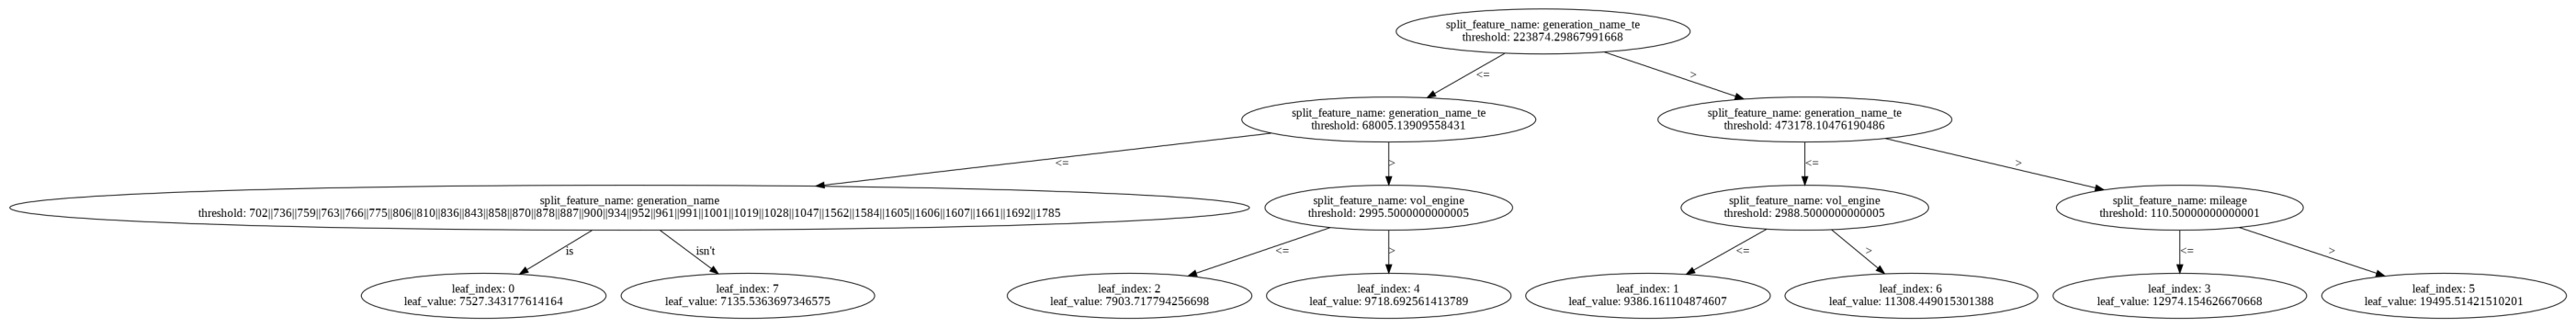

In [ ]:
import matplotlib
lgbm.plot_tree(tree,figsize=(50,50))



Highest Residuals occur on the right branch of the tree root. They occur when generation_name_te > 223000 (average price of the given generation_name) which are the luxury cars. Residuals are especially highest when 
vol_engine and mileage is too high (see the last 4 leaf nodes on the right) which again implies these are the luxury cars. It suggests that expert knowledge is the best when the car is either luxury or it has very high specifications (maybe outliers).



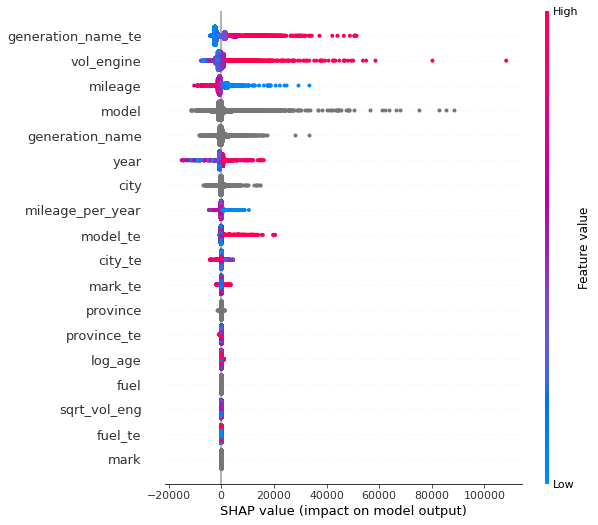

In [ ]:
# shap plot for the residual tree
sur_explainer = shap.TreeExplainer(tree)
sur_shap_values = sur_explainer.shap_values(xx)
shap.summary_plot(sur_shap_values, xx)

This confirms the interpretation of the tree model. Top 3 features are generation_name_te, vol_engine, and mileage that contributes to residuals the most. It may be better to separately analyze the observations with high value of these features since the model performs poorly for these observations.

# Pipeline - Final Train and Scoring Functions

In [ ]:
def cars_train_model(data):
    """
    Train sample model and save artifacts
    Flow:
        - Clean dataset and do feature engineering (Transfrom)
        - Encode columns
        - Train model and encoders
    
    """
    import warnings
    warnings.filterwarnings('ignore')
    import pandas as pd
    import numpy as np
    from category_encoders import TargetEncoder
    from copy import deepcopy
    import lightgbm as lgbm
    import pickle

    def clean_engineer_cars(cars):
        """
        input: raw cars dataframe
        ouput: clean dataframe with new features
        """
        # fill Na for generation_name feature using the combination of related features
        cars['generation_name'].fillna(cars['mark']+cars['model']+cars['year'].astype('string'),inplace=True)

        # Since price may not change linearly in year, I am creating another variable 
        # to represent diminishing depreciation of car's value using log(age) feature. 
        max_year=cars['year'].max()
        cars['log_age']=np.log(max_year-cars['year']+1)

        # create a new variable of mileage and year
        cars['mileage_per_year']=cars['mileage']/(max_year-cars['year']+1)
        
        #create a feature using nonlinear function of vol_engine
        cars['sqrt_vol_eng']=np.sqrt(cars['vol_engine'])
        
        return cars

    #Apply the function to clean data and create new features
    data=clean_engineer_cars(data)
    
    # convert categorical columns to type category
    for col in data.columns:
       if data[col].dtype=='object':
          data[col]=data[col].astype('category')

    '''Train model and encoders'''
    y_train = data['price']
    x_train = data.drop(columns=['price'])

    ## Target encoding
    numerical=['mileage','vol_engine','mileage_per_year','log_age', 'sqrt_vol_eng','year']
    drop_cols=[]
    cat_encoders = {}

    for col in x_train.drop(columns=numerical).columns:
        te=TargetEncoder(handle_missing='value',handle_unknown='value', min_samples_leaf=5, smoothing=0.05)
        te.fit(x_train[col], y_train.values)
        x_train[col+'_te']=te.transform(x_train[col])
        drop_cols.append(col)
        cat_encoders[col] = deepcopy(te)
    # x_train.drop(columns=drop_cols,inplace=True)
    # x_test.drop(columns=drop_cols,inplace=True)
  
    clf=lgbm.LGBMRegressor(colsample_bytree=0.5, learning_rate=0.05, metric='l1',
                  n_estimators=3000, num_leaves=60, subsample=0.4,
                  subsample_for_bin=10000,random_state=0)
    clf.fit(x_train,y_train,eval_set=[(x_train,y_train)],verbose=0)#,(x_test,y_test)
        
    cars_lbgm_file = open("cars_lbgm_model.pkl", "wb")
    cars_encoders_file = open("cars_lbgm_encoders.pkl", "wb")
    pickle.dump(obj=clf, file=cars_lbgm_file)
    pickle.dump(obj=cat_encoders, file=cars_encoders_file)
    
    cars_lbgm_file.close()
    cars_encoders_file.close()
    
    return clf

In [ ]:
def cars_scoring(data):
    """
    Function to score input dataset.
    
    Input: dataset in Pandas DataFrame format
    Output: Python list of labels in the same order as input records
    
    Flow:
        - Load artifacts
        - Transform dataset
        - Score dataset
        - Return labels
    
    """
    import warnings
    warnings.filterwarnings('ignore')
    import pandas as pd
    import numpy as np
    from category_encoders import TargetEncoder
    from copy import deepcopy
    import lightgbm as lgbm
    import pickle    

    def clean_engineer_cars(cars):
        """
        input: raw cars dataframe
        ouput: clean dataframe with new features
        """
        # fill Na for generation_name feature using the combination of related features
        cars['generation_name'].fillna(cars['mark']+cars['model']+cars['year'].astype('string'),inplace=True)

        # Since price may not change linearly in year, I am creating another variable 
        # to represent diminishing depreciation of car's value using log(age) feature. 
        max_year=cars['year'].max()
        cars['log_age']=np.log(max_year-cars['year']+1)

        # create a new variable of mileage and year
        cars['mileage_per_year']=cars['mileage']/(max_year-cars['year']+1)
        
        #create a feature using nonlinear function of vol_engine
        cars['sqrt_vol_eng']=np.sqrt(cars['vol_engine'])
        
        return cars

    #Apply the function to clean data and create new features
    data=clean_engineer_cars(data)
    
    # convert categorical columns to type category
    for col in data.columns:
       if data[col].dtype=='object':
          data[col]=data[col].astype('category')

    y_test = data['price']
    x_test = data.drop(columns=['price'])

    '''Load Model and encoder'''
    cars_lbgm_file = open("cars_lbgm_model.pkl", "rb")
    cars_encoders_file = open("cars_lbgm_encoders.pkl", "rb")
    
    clf = pickle.load(file=cars_lbgm_file)
    enc_dict = pickle.load(cars_encoders_file)
    drop_columns = []
    numerical=['mileage','vol_engine','mileage_per_year','log_age', 'sqrt_vol_eng','year']

    for col in x_test.drop(columns=numerical).columns:
        te=enc_dict[col]
        x_test[col+'_te']=te.transform(x_test[col])
        drop_cols.append(col)

    # x_train.drop(columns=drop_cols,inplace=True)
    # x_test.drop(columns=drop_cols,inplace=True)    
    
    y_pred = clf.predict(x_test)
    
    cars_lbgm_file.close()
    cars_encoders_file.close()

    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    print('MAE=',mean_absolute_error(y_test,y_pred))
    print('MSE=',mean_squared_error(y_test,y_pred))
    print('RMSE=',np.sqrt(mean_squared_error(y_test,y_pred)))
    print('R2=',r2_score(y_test,y_pred))
    return y_pred

## Example Usage

In [ ]:
cars=pd.read_csv('Car_prices_project_2.zip')
train,test=train_test_split(cars,test_size=0.2,random_state=42)
cars_train_model(train)
cars_scoring(test)


Testing accuracy 0.9509
MSE= 344794658.7574345
RMSE= 18568.647197828777
MAE= 7566.109415921832
R2= 0.9509208806989651


array([  8126.40667051,  13099.72544724,  15351.11875896, ...,
       108996.0332007 , 184433.74934596,  18361.48061351])

Note that I have tuned the model to get lower MAE score not MSE as I have explained my reasoning in the final model selection.